# PCA and LDA

In [143]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import scipy.sparse
import scipy.sparse.linalg
from mpl_toolkits import mplot3d


We now want to compute the pca on the MNIST dataset. This dataset cointains images of handwritten digits with dimension 28 x 28, together with number from 0 to 9 representing the lable.

 You are ascked to:

-  Load the dataset in memory and explore its **head** and **shape** to understand how the informations are
placed inside of it

In [144]:
data = pd.read_csv('data.csv')
print(data.head())
data=np.array(data)#now this is a matrix
print(data.shape)

   label  pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  \
0      1       0       0       0       0       0       0       0       0   
1      0       0       0       0       0       0       0       0       0   
2      1       0       0       0       0       0       0       0       0   
3      4       0       0       0       0       0       0       0       0   
4      0       0       0       0       0       0       0       0       0   

   pixel8  ...  pixel774  pixel775  pixel776  pixel777  pixel778  pixel779  \
0       0  ...         0         0         0         0         0         0   
1       0  ...         0         0         0         0         0         0   
2       0  ...         0         0         0         0         0         0   
3       0  ...         0         0         0         0         0         0   
4       0  ...         0         0         0         0         0         0   

   pixel780  pixel781  pixel782  pixel783  
0         0         0         

-  Split the dataset into the X matrix of dimension d × N, with d = 784 being the dimension of each
datum, N is the number of datapoints, and Y ∈ R^N containing the corresponding labels

In [145]:
X=data[:,1:]
X=X.T
Y=data[:,0]
print(X.shape,Y.shape)

(784, 42000) (42000,)


-  Choose a number of digits (for example, 0, 6 and 9) and extract from X and Y the sub-dataset
containing only the considered digits. Re-call X and Y those datasets, since the originals are not
required anymore

In [146]:
digits=(0,6,9)
#for PCA
ind=()
for i in range(len(Y)):
    if Y[i] in digits:
        ind+=(i,)
ind=np.array(ind)
Yp=Y[ind]
Xp=X[:,ind]  
print(Xp.shape,Yp.shape)  
       

(784, 12457) (12457,)


- Set Ntrain < N and randomly sample a training set with Ntrain datapoints from X (and the corresponding Y ). Call them Xtrain and Ytrain. Everything else is the test set. Call it Xtest and
Ytest.


In [147]:
def split_data(X,Y,perctrain):
    index=ind = np.arange(0,X.shape[1]-1)
    np.random.seed(4)
    np.random.shuffle(index)
    Ntrain=int(X.shape[1]*perctrain)
    Xtrain=X[:,index[:Ntrain]]
    Ytrain=Y[index[:Ntrain]]
    Xtest=X[:,index[Ntrain:]]
    Ytest=Y[index[Ntrain:]]
    return Xtrain,Ytrain,Xtest,Ytest
print(Xp.shape) 
print(Yp.shape)   

(784, 12457)
(12457,)


-  Implement the algorithms computing the PCA and LDA of Xtrain with a fixed k. Visualize the results
(for k = 2) and the position of the centroid of each cluster

In [148]:
def PCA(X,Y,k=2):
    C_x=np.mean(X,1)
    C_x=np.expand_dims(C_x,axis=1)
    X_c=X-C_x
    U,S,VT=np.linalg.svd(X_c,full_matrices=False)
    S=np.diag(S)
    X_k=U[:,:k]@S[:k,:k]@VT[:k,:]
    Z_k=U[:,:k].T@X_c
    
    #Now i compute the mean distance
    
    distance=[]
    centroid=[]
    for i in range(len(digits)):
        C_R2=np.mean(Z_k[:,Y==digits[i]],axis=1)
        centroid.append(C_R2)
        dist=Z_k[:,Y==digits[i]]-np.repeat(C_R2.reshape(k,1),Z_k[:,Y==digits[i]].shape[1],axis=1)
        dist=[np.linalg.norm(dist[:,j],2) for j in range((dist.shape[1]))]
        dist=np.mean(dist)
        distance.append(dist)
    distances={}
    for i,e in enumerate(digits):
        distances[e]=distance[i]
    
    
    return (Z_k,U[:,:k].T,np.array(centroid))


def LDA(Xt,Yt,K):
    Xvec=[]
    Yvec=[]
    for i in digits:
        Xvec.append(Xt[:,Yt==i])
        Yvec.append(Yt[Yt==i])
    X=np.concatenate(Xvec,axis=1)
    Y=np.concatenate(Yvec)
    Cvec=[]
    for i,d in enumerate(digits):
        Cvec.append(np.mean(Xvec[i],axis=1))
    C=np.mean(X,axis=1)
    Xcvec=[]
    for i,e in enumerate(digits):
        Xcvec.append(Xvec[i]-Cvec[i].reshape((Xvec[i].shape[0],1)))
    Xw=np.concatenate(Xcvec,axis=1)
    #Xw=np.concatenate((X1c,X2c,X3c),axis=1)
    Sw=Xw @ Xw.T
    Xbar=[]
    for i,e in enumerate(digits):
        Xbar.append(np.repeat(Cvec[i].reshape(Xvec[i].shape[0],1),Xvec[i].shape[1],axis=1))
    Xbar=np.concatenate(Xbar,axis=1)
    Xbarc=Xbar-C.reshape((Xbar.shape[0],1))
    Sb=Xbarc @ Xbarc.T
    try:
        L=np.linalg.cholesky(Sw)
    except:
        epsilon=1e-6
        Sw=Sw+epsilon*np.eye(Sw.shape[0])
        L=np.linalg.cholesky(Sw)
    _,W=scipy.sparse.linalg.eigs(np.linalg.inv(L) @ Sb @ L,k=K)
    W=np.real(W)
    Q=np.linalg.inv(L).T @ W
    Z=Q.T @ X
    
    
    #now i compute the mean distance
    centroid=[]
    
    for i in range(len(digits)):
        C_R2=np.mean(Z[:,Y==digits[i]],axis=1)
        centroid.append(C_R2)
    return (Z, Q.T,np.array(centroid))
    
def Plot_PCA_LDA(Y,Z_k,Zl,CPCA,CLDA,plot_test=False): 
    distance=[]
    centroid=[]
    for i in range(len(digits)):
        C_R2=CPCA[i]
        centroid.append(C_R2)
        dist=Z_k[:,Y==digits[i]]-np.repeat(C_R2.reshape(Z_k.shape[0],1),Z_k[:,Y==digits[i]].shape[1],axis=1)
        dist=[np.linalg.norm(dist[:,j],2) for j in range((dist.shape[1]))]
        dist=np.mean(dist)
        distance.append(dist)
    distances={}
    for i,e in enumerate(digits):
        distances[e]=distance[i]
    print("PCA distances: ",distances)
    Cp=[]
    for i in range(len(digits)):
        Cp.append(CPCA[i])
    Cp=np.array(Cp)
    fig=plt.figure(figsize=(10, 4))
    if Z_k.shape[0]==3:
        ax = fig.add_subplot(1, 2, 1, projection='3d')
        ax.set_title("PCA")
        for ind,i in enumerate(digits):
            ax.scatter(Z_k[0,Y==i],Z_k[1,Y==i],Z_k[2,Y==i],marker='^')
        for ind,i in enumerate(digits):
            ax.scatter(Cp[ind,0],Cp[ind,1],Cp[ind,2],color="red")
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        ax.legend([f"{i}" for i in digits]+["centroid"])
    else:
        plt.subplot(1, 2, 1)
        for ind,i in enumerate(digits):
            plt.scatter(Z_k[0,Y==i],Z_k[1,Y==i])
        for i in range(len(digits)):
            plt.scatter(Cp[i][0],Cp[i][1],marker="o",color="red")
        plt.grid()
        plt.legend([f"{i}" for i in digits]+["centroid"])
    
    if plot_test==False:
        Yl=[]
        for i in digits:
            Yl.append(Y[Y==i])   
        Y=np.concatenate(Yl)
    Cl=[]
    distance=[]
    centroid=[] 
    for i in range(len(digits)):
        C_R2=CLDA[i]
        centroid.append(C_R2)
        dist=Zl[:,Y==digits[i]]-np.repeat(C_R2.reshape(Zl.shape[0],1),Zl[:,Y==digits[i]].shape[1],axis=1)
        dist=[np.linalg.norm(dist[:,j],2) for j in range((dist.shape[1]))]
        dist=np.mean(dist)
        distance.append(dist)
    distances={}
    for i,e in enumerate(digits):
        distances[e]=distance[i]
    print("LDA distances: ",distances)
    for i in range(len(digits)):
        Cl.append(CLDA[i])
    Cl=np.array(Cl)
    if Zl.shape[0]==3:
            ax = fig.add_subplot(1, 2, 2, projection='3d')
            ax.set_title("LDA")
            for i, e in enumerate(digits):
               ax.scatter(Zl[0,Y==e],Zl[1,Y==e],Zl[2,Y==e],marker='^')
            for i, e in enumerate(digits):   
                ax.scatter(Cl[i,0],Cl[i,1],Cl[i,2],marker="o",color="red")
            ax.set_xlabel('X')
            ax.set_ylabel('Y')
            ax.set_zlabel('Z')
            ax.legend([f"{i}" for i in digits]+["centroid"])
    else:
        plt.subplot(1, 2, 2)
        for i, e in enumerate(digits):
            plt.scatter(Zl[0,Y==e],Zl[1,Y==e])
        for i in range(len(digits)):
            centroidl=plt.scatter(Cl[i][0],Cl[i][1],marker="o",color="red")
        plt.legend([f"{i}" for i in digits]+["centroid"])
        plt.grid()
        plt.show()
   
def classify(Z,Y_test,Centroid):
    Ztest=Z
    lable=np.linspace(0,Ztest.shape[1]-1,Ztest.shape[1],dtype=int)
    C=Centroid
    distance=np.zeros((len(digits),))  
    for i in range(Ztest.shape[1]):
            for j,e in enumerate(digits):
                distance[j]=np.linalg.norm((np.expand_dims(Ztest[:,i],axis=0)-C[j]),2)
            lable[i]=digits[np.argmin(distance)]
    howmany=[0 for i in range(len(digits))]
    correct_digits=0
    for i in range(len(digits)):
        howmany[i]=int(np.count_nonzero(lable==digits[i])) 
    for i in range(len(lable)):
        if lable[i]==Y_test[i]:
             correct_digits+=1
       # print(f"ci sono {digits[i]}:",howmany[i])   
    return correct_digits/(len(Y_test))



In [149]:
Xtrain ,Ytrain, Xtest,Ytest=split_data(Xp,Yp,0.8)

PCA distances:  {0: 729.7361686649717, 6: 535.7988977615369, 9: 364.3725850630807}
LDA distances:  {0: 0.01232605488476513, 6: 0.011495772868423995, 9: 0.011552970461145274}


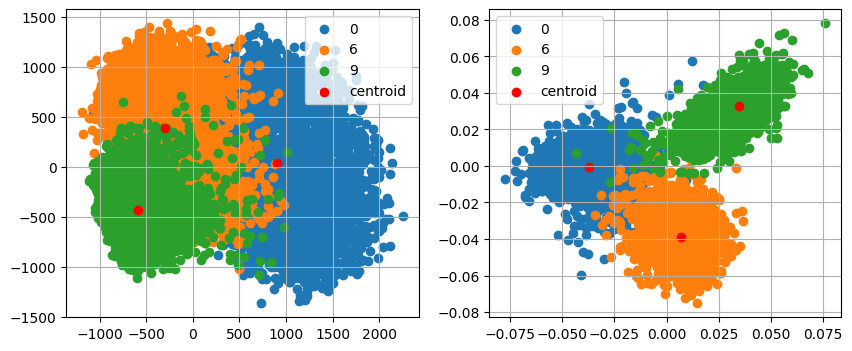

PCA distances:  {0: 741.5412704706018, 6: 539.4994755090152, 9: 359.7310710684646}
LDA distances:  {0: 0.013045801795935594, 6: 0.012261328642163172, 9: 0.012460853405143725}


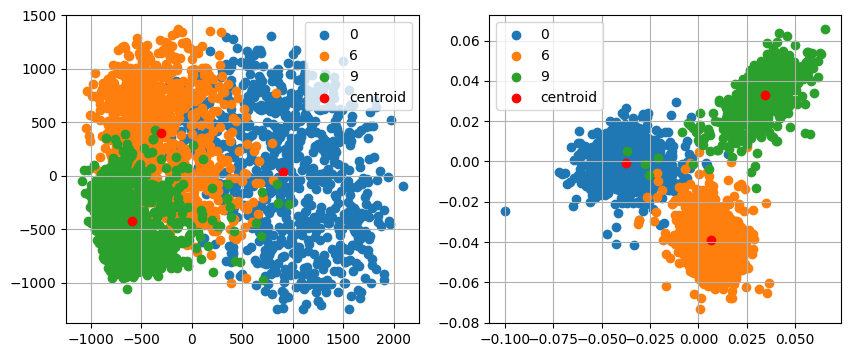

Percentage of Correct classification for PCA: 0.8410276997189884
Percentage of Correct classification for LDA: 0.9847450822962666


In [150]:
PCA_train=PCA(Xtrain,Ytrain,2)
LDA_train=LDA(Xtrain,Ytrain,2)

Plot_PCA_LDA(Ytrain,PCA_train[0],LDA_train[0],PCA_train[2],LDA_train[2])
ZtestPCA=PCA_train[1]@(Xtest-np.expand_dims(np.mean(Xtest,axis=1),axis=1))
ZtestLDA=LDA_train[1]@Xtest
Plot_PCA_LDA(Ytest,ZtestPCA,ZtestLDA,PCA_train[2],LDA_train[2],plot_test=True)

print("Percentage of Correct classification for PCA:",classify(ZtestPCA,Ytest,PCA_train[2]))
print("Percentage of Correct classification for LDA:",classify(ZtestLDA,Ytest,LDA_train[2]))

PCA distances:  {0: 848.6408603411851, 6: 704.4035102485514, 9: 483.67747994915806}
LDA distances:  {0: 0.012326265691199066, 6: 0.011495958018424502, 9: 0.01155314585396513}
PCA distances:  {0: 859.524031199965, 6: 697.7062417615429, 9: 485.22809396404716}
LDA distances:  {0: 0.1916247630458487, 6: 2.999863162960499, 9: 36.32163109987543}
Percentage of Correct classification for PCA: 0.927739863508631
Percentage of Correct classification for LDA: 0.9843436370935368


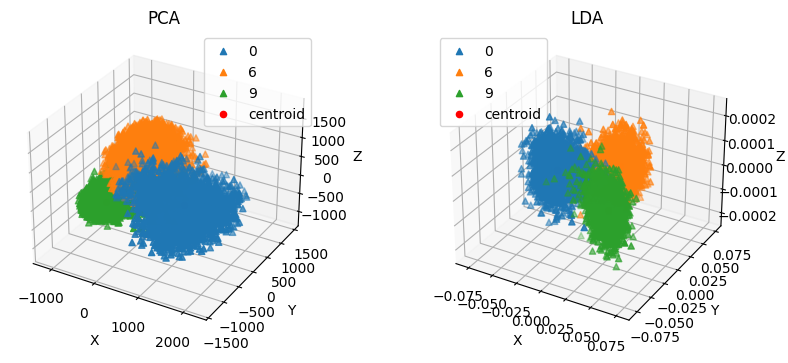

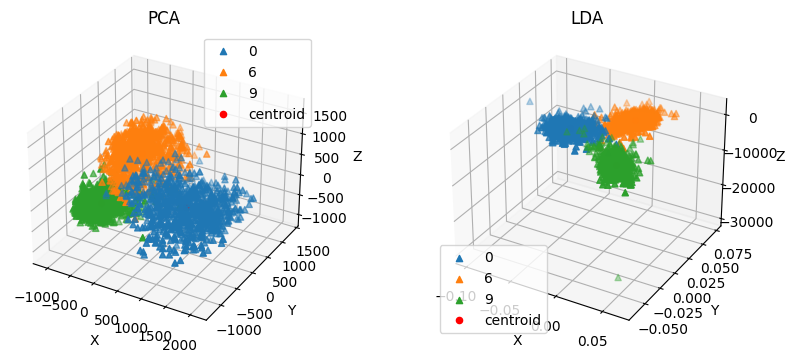

In [151]:
PCA_train=PCA(Xtrain,Ytrain,3)
LDA_train=LDA(Xtrain,Ytrain,3)

Plot_PCA_LDA(Ytrain,PCA_train[0],LDA_train[0],PCA_train[2],LDA_train[2])
ZtestPCA=PCA_train[1]@(Xtest-np.expand_dims(np.mean(Xtest,axis=1),axis=1))
ZtestLDA=LDA_train[1]@Xtest
Plot_PCA_LDA(Ytest,ZtestPCA,ZtestLDA,PCA_train[2],LDA_train[2],plot_test=True)

print("Percentage of Correct classification for PCA:",classify(ZtestPCA,Ytest,PCA_train[2]))
print("Percentage of Correct classification for LDA:",classify(ZtestLDA,Ytest,LDA_train[2]))






In [152]:
PCA_train=PCA(Xtrain,Ytrain,10)
LDA_train=LDA(Xtrain,Ytrain,10)

ZtestPCA=PCA_train[1]@(Xtest-np.expand_dims(np.mean(Xtest,axis=1),axis=1))
ZtestLDA=LDA_train[1]@Xtest

print("Percentage of Correct classification for PCA:",classify(ZtestPCA,Ytest,PCA_train[2]))
print("Percentage of Correct classification for LDA:",classify(ZtestLDA,Ytest,LDA_train[2]))

Percentage of Correct classification for PCA: 0.951023685266961
Percentage of Correct classification for LDA: 0.9835407466880771


In [153]:
PCA_train=PCA(Xtrain,Ytrain,20)
LDA_train=LDA(Xtrain,Ytrain,20)

ZtestPCA=PCA_train[1]@(Xtest-np.expand_dims(np.mean(Xtest,axis=1),axis=1))
ZtestLDA=LDA_train[1]@Xtest

print("Percentage of Correct classification for PCA:",classify(ZtestPCA,Ytest,PCA_train[2]))
print("Percentage of Correct classification for LDA:",classify(ZtestLDA,Ytest,LDA_train[2]))

Percentage of Correct classification for PCA: 0.9518265756724207
Percentage of Correct classification for LDA: 0.9831393014853472


In [154]:
acc_lda=[]
acc_pca=[]
for k in range(2,780,50):
    PCA_train=PCA(Xtrain,Ytrain,k)
    LDA_train=LDA(Xtrain,Ytrain,k)

    ZtestPCA=PCA_train[1]@(Xtest-np.expand_dims(np.mean(Xtest,axis=1),axis=1))
    ZtestLDA=LDA_train[1]@Xtest

    acc_pca.append(classify(ZtestPCA,Ytest,PCA_train[2])) 
    acc_lda.append(classify(ZtestLDA,Ytest,LDA_train[2])) 

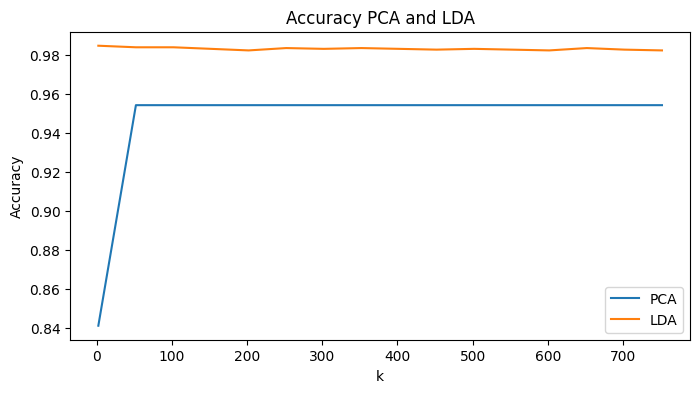

In [161]:

plt.figure(figsize=[8,4])
plt.title("Accuracy PCA and LDA")
plt.plot(range(2,780,50),acc_pca)
plt.plot(range(2,780,50),acc_lda)
plt.xlabel("k")
plt.ylabel("Accuracy")
plt.legend(["PCA","LDA"]);

# Visualizing Dyad

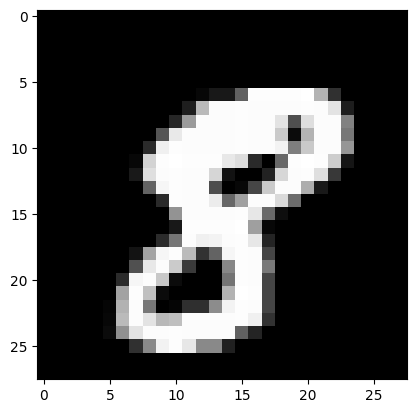

k=   0


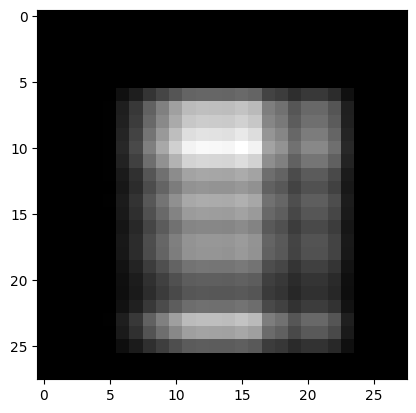

k=   1


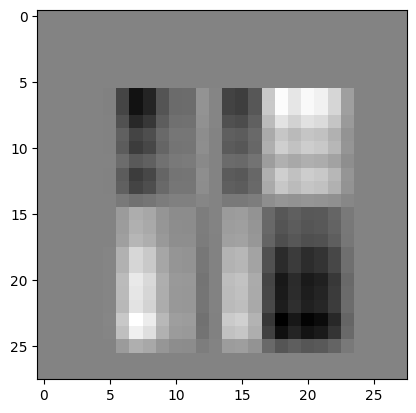

k=   2


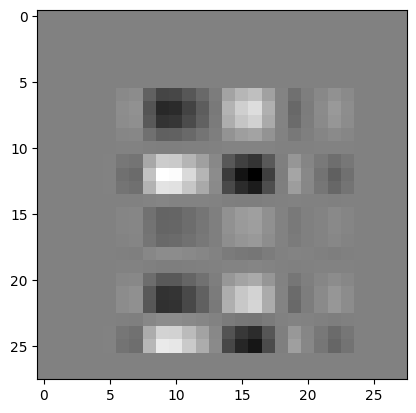

k=   3


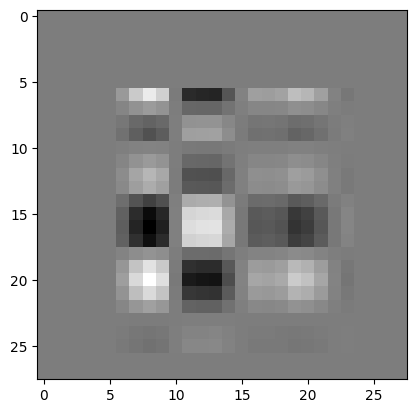

k=   4


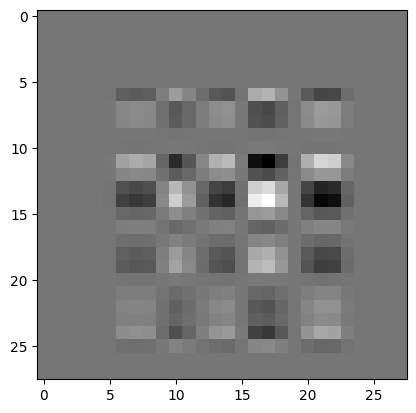

k=   5


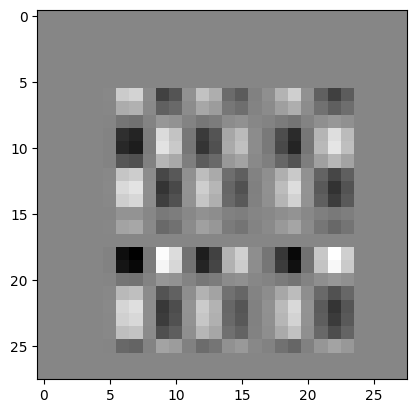

k=   6


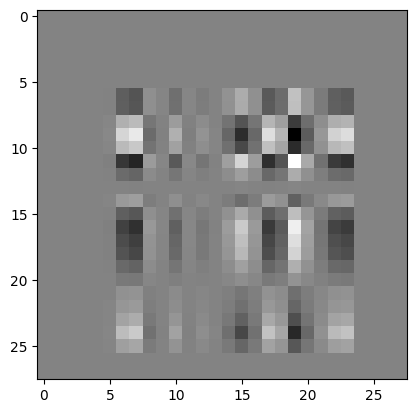

k=   7


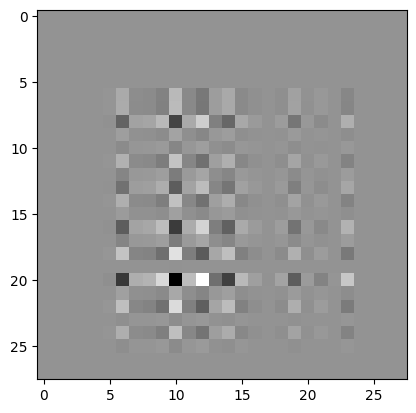

k=   8


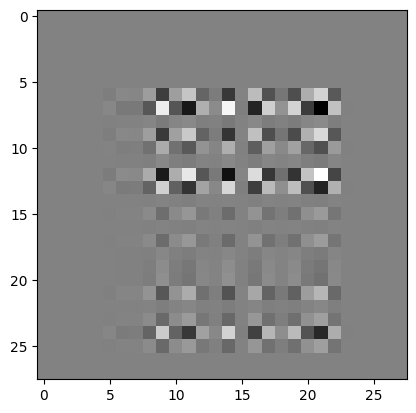

k=   9


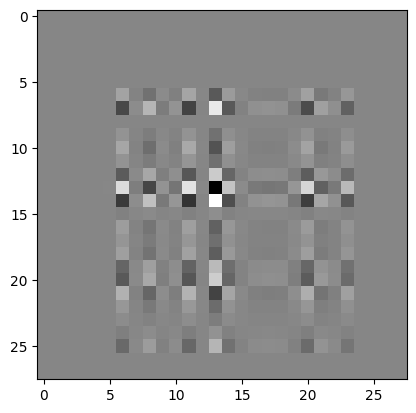

In [156]:
data=pd.read_csv("data.csv")
data=np.array(data)
X=data[:,1:]
X=X.T
index=10
image=X[:,index]
image=np.reshape(image,(28,28))
plt.imshow(image,cmap="gray")
plt.show()
U, S, VT=np.linalg.svd(image)
k=10
A=np.zeros((28,28))
for i in range(10):
    A=(np.reshape(U[:,i],(28,1))@np.reshape(VT[i,:],(1,28)))*S[i]
    print("k=  ",i)
    A=np.reshape(A,(28,28))
    plt.imshow(A,cmap="gray")
    plt.show()


I can notice that more we go, more we have tiny squares of gray.

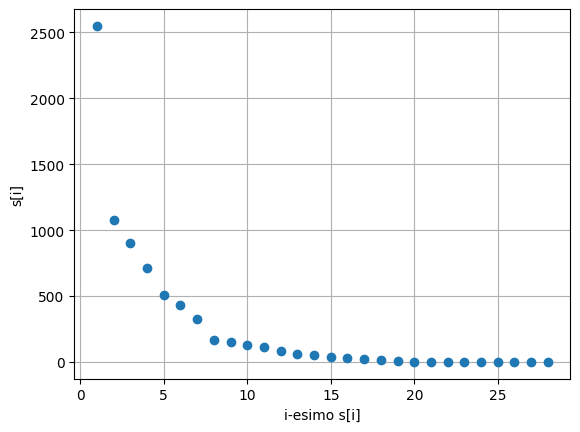

In [157]:

ind=np.linspace(1,image.shape[1],image.shape[1],dtype=int)
plt.plot(ind, S,"o")
plt.grid()
plt.xlabel("i-esimo s[i]")
plt.ylabel("s[i]")
plt.show()

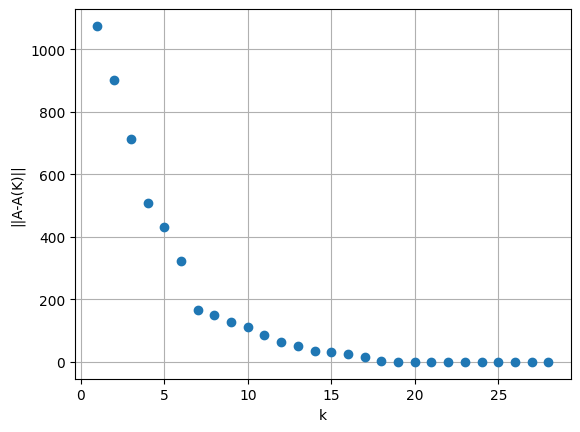

In [158]:
vec_error=()
A=np.zeros((28,28))
for i in range(28):
    A+=(np.reshape(U[:,i],(28,1))@np.reshape(VT[i,:],(1,28)))*S[i]
   # print("k=  ",i)
    A=np.reshape(A,(28,28))
    error=np.linalg.norm(image-A,2)
    vec_error+=(error,)
   # plt.imshow(A,cmap="gray")
    #plt.show()
vec_error=np.array(vec_error)
plt.plot(ind,vec_error,"o")
plt.grid()
plt.xlabel("k")
plt.ylabel("||A-A(K)||")
plt.show()

We can notice the  Eckart-young Theorem ||A-A(k)||_2=s[k+1]

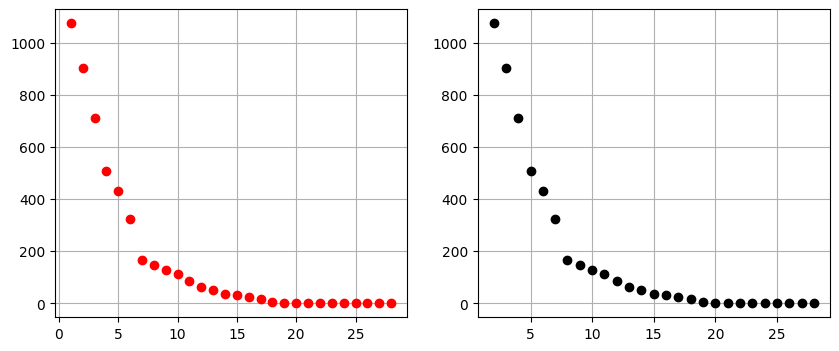

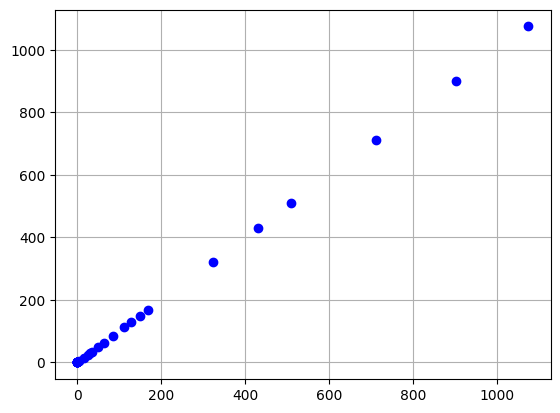

In [159]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(ind, vec_error, 'o', color='red')
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(ind[1:], np.array(S[1:]), 'o', color='k')
plt.grid()

plt.show()

plt.plot(S[1:],vec_error[:27],"o",color="blue")
plt.grid()
plt.show()

### Plotting the compression factor

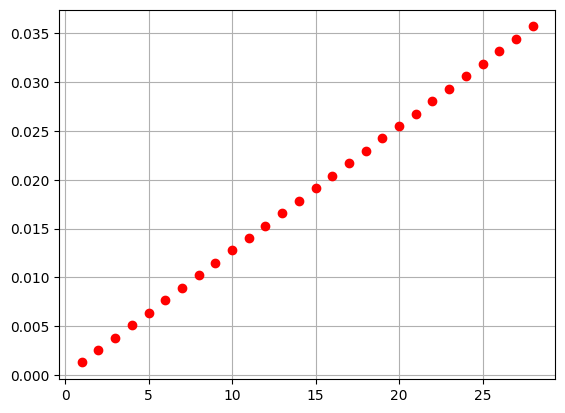

In [160]:
vec_comFactor=ind/(28*28)
plt.plot(ind,vec_comFactor,"o",color="red")
plt.grid()
plt.show()